#### <b>aplication</b>

<h5 style="margin-left:2em;">datasets</h5>

In [6]:
import pandas as pd

In [7]:
rest = pd.read_parquet("../Datasets/florida_restaurants.parquet")
rest.head(1)

,id_nombre,nombre,id_ciudad,latitud,longitud,categorias,puntuacion_usuarios
0,0,taverna opa-tampa,RGTW,27.95169,-82.458753,"Restaurants, Greek",2.5


In [8]:
yearly = pd.read_parquet("../Datasets/florida_yearly.parquet")
yearly.head(1)

,id_nombre,año,id_ciudad,categorias,puntuacion_usuarios
0,0,2010,RGTW,"Restaurants, Greek",2.5


In [9]:
cities = pd.read_parquet("../Datasets/florida_cities.parquet")
cities.head(1)

,id_ciudad,ciudad
0,Q2Pa,Miami Lakes


<h5 style="margin-left:2em;">AdaBoost Regressor para <small><i>yearly</i></small></h5>

El modelo se puede expresar en 2 configuraciones
* Por restaurante [id_nombre == id_nombre]
* Por categoria [categoria in categories]

In [10]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from typing import Literal
import numpy as np

Predicted value for 2023: [3.5, 0.0]


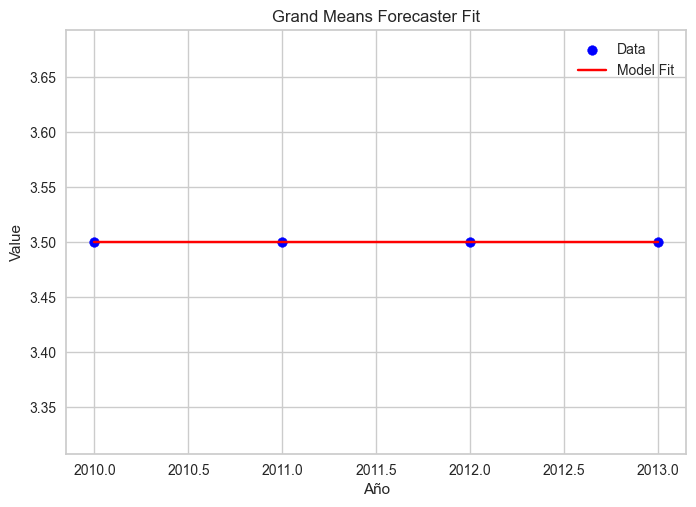

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

class GrandMeansForecaster:
    def __init__(self, degree=2):
        """
        Initializes the forecaster with a polynomial regression model.
        :param degree: Degree of the polynomial to fit.
        """
        self.model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    
    def fit_predict(self, df:pd.DataFrame, year):
        """
        Fits the model to the provided data.
        :param df: DataFrame with columns "año" and "value".
        """
        df_ordered = df.sort_values(by=["año"])
        X = df_ordered[['año']].values
        y = df_ordered['value'].values
        self.model.fit(X, y)

        pr = self.model.predict([[year]])[0]
        if pr>5:
            pr = 5.0
        elif pr<0:
            pr = 0.0
        
        if year-1 in X:
            prev = df_ordered[df_ordered['año']== year-1 ]["value"].values[0]
        else:
            prev = self.model.predict([[year-1]])[0]
            if prev>5:
                prev = 5.0
            elif prev<0:
                prev = 0.0

        diff = pr - prev
        return [pr, diff]
    
    def visualize(self, df):
        """
        Visualizes the fit of the model on the data.
        :param df: DataFrame with columns "año" and "value".
        """
        plt.scatter(df['año'], df['value'], color='blue', label='Data')
        years = np.linspace(df['año'].min(), df['año'].max(), 500)
        predictions = self.model.predict(years.reshape(-1, 1))
        plt.plot(years, predictions, color='red', label='Model Fit')
        plt.xlabel('Año')
        plt.ylabel('Value')
        plt.legend()
        plt.title('Grand Means Forecaster Fit')
        plt.show()

# Example usage: #! Remove on deployment code
# Sample data
target_data = yearly[yearly["id_nombre"] == 1451]
target_data = target_data[["año", "puntuacion_usuarios"]]
# Verificar si hay datos suficientes
if len(target_data) < 2:
    print("No hay suficientes datos para hacer un pronóstico.") #! Remove on deployment


target_data.sort_values(by=['año'], inplace=True)
data = {
    "año": target_data["año"].values,
    "value": target_data["puntuacion_usuarios"].values
}
df = pd.DataFrame(data)

# Initialize, train, and predict
forecaster = GrandMeansForecaster(degree=3)

predicted_value = forecaster.fit_predict(df, 2023)
print(f"Predicted value for 2023: {predicted_value}")

# Visualize
forecaster.visualize(df)

##### Por restaurante:

In [12]:
def tendency_restaurant(id_nombre:int, year:int=2023,  *, target:Literal["puntuacion_usuarios", "puntuacion_yelp"]="puntuacion_usuarios")-> None | list[float]:
    target_data = yearly[yearly["id_nombre"] == id_nombre]
    target_data = target_data[["año", target]]
    # Verificar si hay datos suficientes
    if len(target_data) < 2:
        print("No hay suficientes datos para hacer un pronóstico.") #! Remove on deployment


    target_data.sort_values(by=['año'], inplace=True)
    data = {
        "año": target_data["año"].values,
        "value": target_data[target].values
    }
    df = pd.DataFrame(data)

    # Initialize, train, and predict
    forecaster = GrandMeansForecaster(degree=3)

    predicted_value = forecaster.fit_predict(df, year)
    print(f"Predicted value for {year}: {predicted_value[0]:.2f}, for a difference of {predicted_value[1]:.2f}")

    return predicted_value

In [13]:
tendency_restaurant(0)

Predicted value for 2023: 2.50, for a difference of 0.00


[2.5, 0.0]

##### Por categoria:

In [17]:
def tendency_category(category: str, city_parquet_id: int | None = None, year:int=2023,  *, target:Literal["puntuacion_usuarios", "puntuacion_yelp"]="puntuacion_usuarios")-> None | list[float]:
    if city_parquet_id is not None:
        target_data = yearly[yearly["id_ciudad"] == city_parquet_id]
        target_data = target_data[["año", target]]
    else:
        target_data = target_data[["año", target]]
    
    
    target_data = yearly[yearly['categorias'].str.contains(category)]

    # Agrupar por año y calcular la puntuación promedio de todos los restaurantes
    target_data = target_data.groupby('año')[target].mean().reset_index()
    
    # Verificar si hay datos suficientes
    if len(target_data) < 2:
        print("No hay suficientes datos para hacer un pronóstico.") #! Remove on deployment


    target_data.sort_values(by=['año'], inplace=True)
    data = {
        "año": target_data["año"].values,
        "value": target_data[target].values
    }
    df = pd.DataFrame(data)

    # Initialize, train, and predict
    forecaster = GrandMeansForecaster(degree=3)

    predicted_value = forecaster.fit_predict(df, year)
    print(f"Predicted value for {year}: {predicted_value[0]:.2f}, for a difference of {predicted_value[1]:.2f}")

    return predicted_value

In [18]:
tendency_category("Bars", 20, 2023)

Predicted value for 2023: 3.99, for a difference of 0.02


[3.9905121624469757, 0.015838959832596533]